Successfully loaded the data

Train data set statistics
 
('distance map shape', (1, 256, 256))
('feaature shapes', (1, 256, 256))
('type of the predicted distance map', <type 'numpy.ndarray'>)


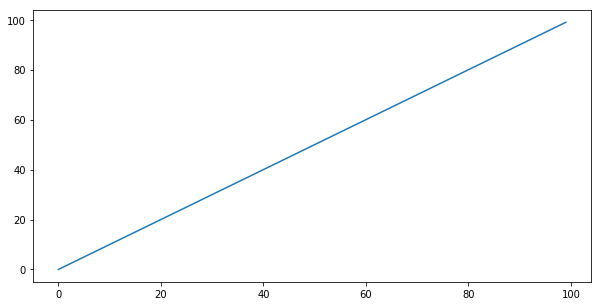

In [87]:
import sys
sys.dont_write_bytecode = True

import matplotlib.pyplot as plt

import os

from dataloader_un import npy_train,npy_valid

import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"]="0"


DATA_DIR='/home/SSD/protien_ICMLA/'
BATCH_SIZE = 7


train_dataset = npy_train(os.path.join(DATA_DIR),transforms=np.load('./LOG_mean_max_train.npy'))
#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=4)



print("Successfully loaded the data")

print("")

print("Train data set statistics")
print(" ")
print('distance map shape', train_dataset[0][1].shape)
print('feaature shapes', train_dataset[0][0][3:4, :, :].shape)
print("type of the predicted distance map", type(train_dataset[0][1]))

plt.plot(np.arange(100))

In [88]:
x = train_dataset[0][0][3, :, :]

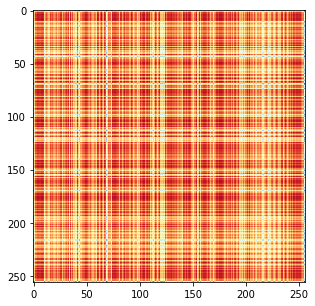

In [89]:
plt.imshow(x, cmap='RdYlBu', interpolation='nearest')
plt.show()

In [90]:
x.shape

(256, 256)

In [91]:
y = train_dataset[0][1]

In [92]:
y.shape

(1, 256, 256)

In [93]:
yy = np.transpose(y, (2, 1, 0))

In [94]:
yy.shape

(256, 256, 1)

In [95]:
yy = yy[:, :, 0]

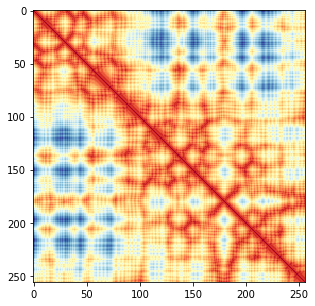

In [96]:
plt.imshow(yy, cmap='RdYlBu', interpolation='nearest')
plt.show()

In [97]:
%matplotlib inline

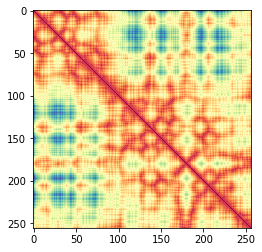

In [98]:
plt.imshow(yy, cmap='Spectral', interpolation='nearest')
# plt.savefig('map.png')

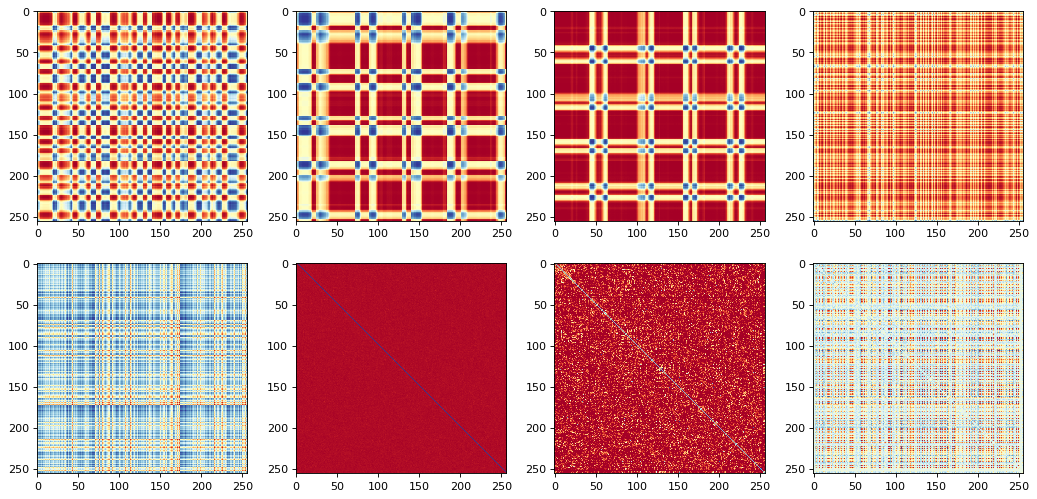

In [99]:
plt.figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', frameon=True, edgecolor='k')
for i in range(8):
    plt.subplot(4, 4, i + 1)
    #plt.grid(None)
    plt.imshow(train_dataset[7][0][i, :, :], cmap='RdYlBu', interpolation='nearest')

In [118]:
import numpy as np

################################################################################
flag_show_plots = True # True for Notebooks, False otherwise
if flag_show_plots:
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure

################################################################################
dirlocal = './dataset/'
dirgcp = 'gs://protein-distance/'
dirpredictions = './predictions/' # only if building 3D models

dataset = 'sample' # 'sample' or 'full'

# stamp = datetime.datetime.now().strftime('%m_%d_%Y_%H_%M_%S_%f')
# modelfile = 'model-' + str(stamp) + '.h5'

################################################################################
def determine_number_of_channels(input_features, pdb_list, length_dict):
    F = 0
    x = input_features[pdb_list[0]]
    l = length_dict[pdb_list[0]]
    for feature in x:
        if len(feature) == l:
            F += 2
        elif len(feature) == l * l:
            F += 1
        else:
            print('Expecting features to be either L or L*L !! Something went wrong!!', l, len(feature))
            sys.exit(1)
    return F

################################################################################
# Roll out 1D features to two 2D features, all to 256 x 256 (because many are smaller)
def prepare_input_features_2D(pdbs, input_features, distance_maps_cb, length_dict, F):
    X = np.full((len(pdbs), 256, 256, F), 0.0)
    Y = np.full((len(pdbs), 256, 256, 1), 100.0)
    for i, pdb in enumerate(pdbs):
        x = input_features[pdb]
        y = distance_maps_cb[pdb]
        l = length_dict[pdb]
        newi = 0
        xmini = np.zeros((l, l, F))
        for feature in x:
            feature = np.array(feature)
            feature = feature.astype(np.float)
            if len(feature) == l:
                for k in range(0, l):
                    xmini[k, :, newi] = feature
                    xmini[:, k, newi + 1] = feature
                newi += 2
            elif len(feature) == l * l:
                xmini[:, :, newi] = feature.reshape(l, l)
                newi += 1
            else:
                print('Expecting features to be either L or L*L !! Something went wrong!!', l, len(feature))
                sys.exit(1)
        if l > 256:
            l = 256
        X[i, 0:l, 0:l, :] = xmini[:l, :l, :]
        Y[i, 0:l, 0:l, 0] = y[:l, :l]
    return X, Y
######################################


def show_out():
    ################################################################################
    print('')
    print('Load input features..')
    x = dirlocal + dataset + '-input-features.npy'
    if not os.path.isfile(x):
        x = BytesIO(file_io.read_file_to_string(dirgcp + dataset + '-input-features.npy', binary_mode=True))
    (pdb_list, length_dict, input_features) = np.load(x, encoding='latin1',allow_pickle = True)

    ################################################################################
    print('')
    print('Load distance maps..')
    x = dirlocal + dataset + '-distance-maps-cb.npy'
    if not os.path.isfile(x):
        x = BytesIO(file_io.read_file_to_string(dirgcp + dataset + '-distance-maps-cb.npy', binary_mode=True))
    (pdb_list_y, distance_maps_cb) = np.load(x, encoding='latin1',allow_pickle = True)

    ################################################################################
    print('')
    print ('Some cross checks on data loading..')
    for pdb in pdb_list:
        if not pdb in pdb_list_y:
            print ('I/O mismatch ', pdb)
            sys.exit(1)

    ################################################################################
    print('')
    print('Find the number of input channels..')
    F = determine_number_of_channels(input_features, pdb_list, length_dict)

    ################################################################################
    print('')
    print('Split into training and validation set (4%)..')
    split = int(0.04 * len(pdb_list))
    valid_pdbs = pdb_list[:split]
    train_pdbs = pdb_list[split:]

    print('Total validation proteins = ', len(valid_pdbs))
    print('Total training proteins = ', len(train_pdbs))

    ################################################################################
    print('')
    print ('Prepare the validation input and outputs..')
    XVALID, YVALID = prepare_input_features_2D(valid_pdbs, input_features, distance_maps_cb, length_dict, F)
    print(XVALID.shape)
    print(YVALID.shape)

    print('')
    print ('Prepare the training input and outputs..')
    XTRAIN, YTRAIN = prepare_input_features_2D(train_pdbs, input_features, distance_maps_cb, length_dict, F)
    print(XTRAIN.shape)
    print(YTRAIN.shape)
    
    return XTRAIN, YTRAIN
    
    

In [119]:
x, y = show_out()


Load input features..

Load distance maps..

Some cross checks on data loading..

Find the number of input channels..

Split into training and validation set (4%)..
('Total validation proteins = ', 8)
('Total training proteins = ', 192)

Prepare the validation input and outputs..
(8, 256, 256, 13)
(8, 256, 256, 1)

Prepare the training input and outputs..
(192, 256, 256, 13)
(192, 256, 256, 1)


In [102]:
x.shape

(192, 256, 256, 13)

In [103]:
y.shape

(192, 256, 256, 1)

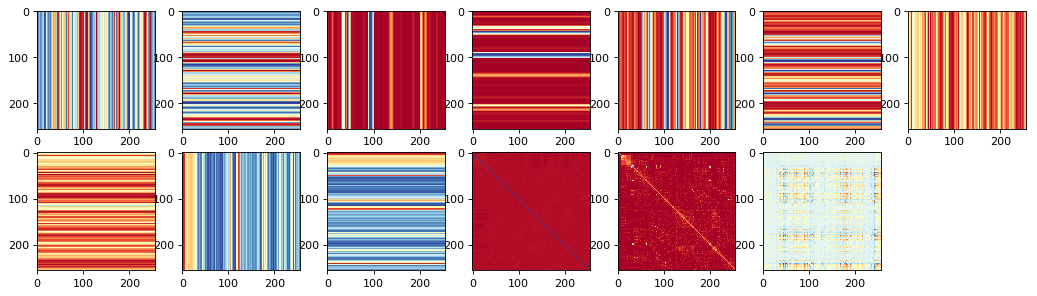

In [104]:
plt.figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', frameon=True, edgecolor='k')
for i in range(13):
    plt.subplot(7, 7, i + 1)
    #plt.grid(None)
    plt.imshow(x[7, :, :, i], cmap='RdYlBu', interpolation='nearest')

In [105]:
x[7:, :, 12] == train_dataset[7][0][7, :, :]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [106]:
x[7,:, :, 12].shape

(256, 256)

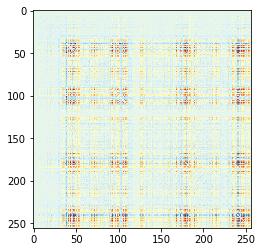

In [107]:
plt.imshow(x[7,:, :, 12], cmap='RdYlBu', interpolation='nearest')

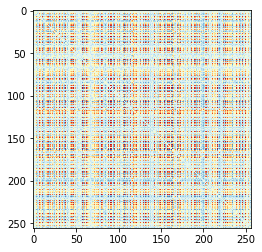

In [108]:
plt.imshow(train_dataset[7][0][7, :, :], cmap='RdYlBu', interpolation='nearest')

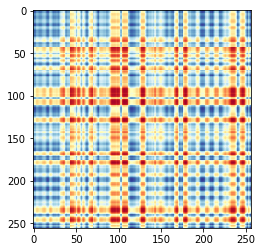

In [109]:
plt.imshow((x[7, :, :, 0] + x[7, :, :, 1]) / 2, cmap='RdYlBu', interpolation='nearest')

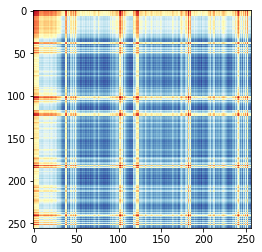

In [110]:
plt.imshow((x[7, :, :, 8] + x[7, :, :, 9]) / 2, cmap='RdYlBu', interpolation='nearest')

In [111]:
plt.rcParams['figure.figsize'] = (25, 25)

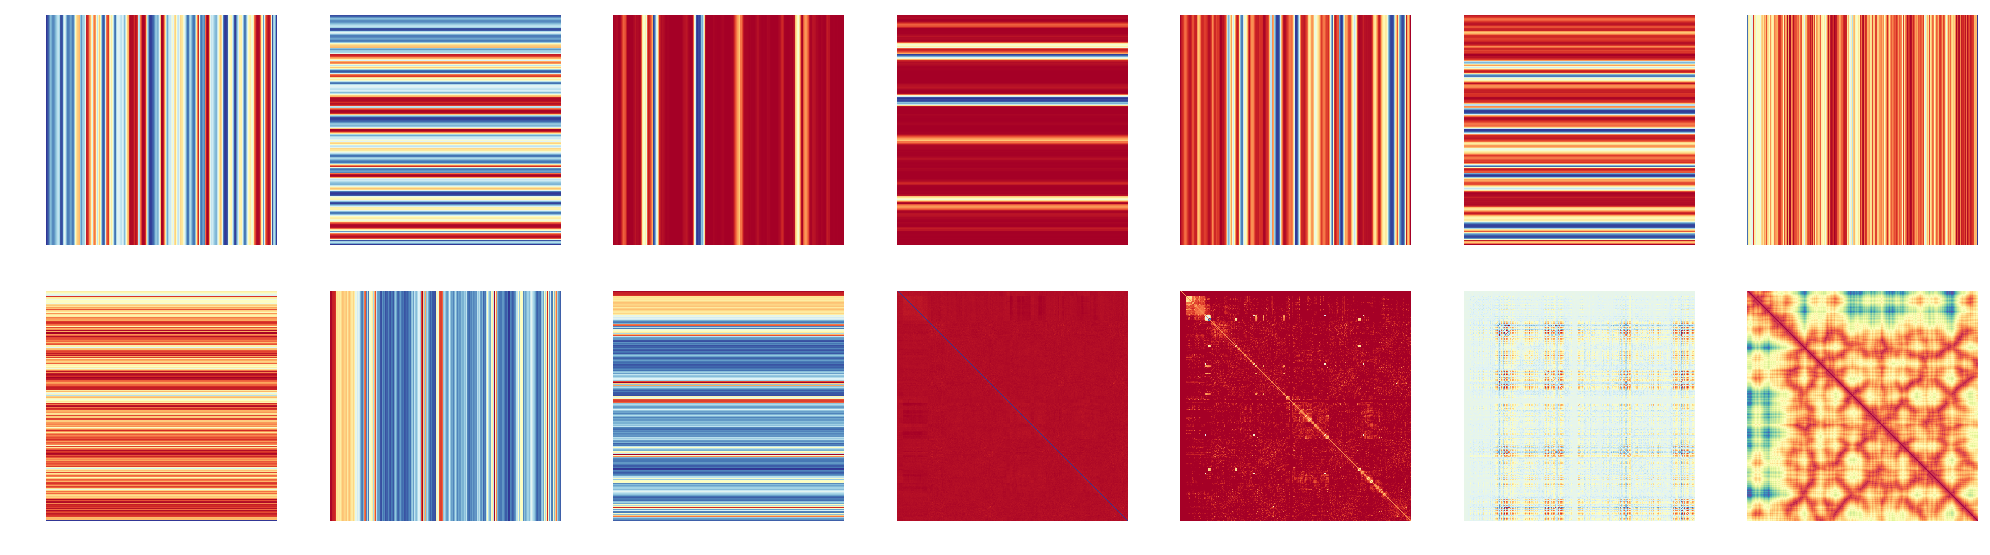

In [112]:
plt.figure(num=None, figsize=(25, 25), dpi=100, facecolor='w', frameon=True, edgecolor='k')
for i in range(13):
    plt.subplot(7, 7, i + 1)
    
    plt.axis('off')
    plt.imshow(x[7, :, :, i], cmap='RdYlBu', interpolation='nearest')
plt.subplot(7, 7, 14)
plt.axis('off')
plt.imshow(y[7, :, :, 0], cmap='Spectral', interpolation='nearest')
plt.savefig('orginal_input_output.png', dpi=300, facecolor='w', edgecolor='k',
          orientation='portrait', papertype=None, format=None,
          transparent=False, bbox_inches=None, pad_inches=0.1,
          frameon=True)

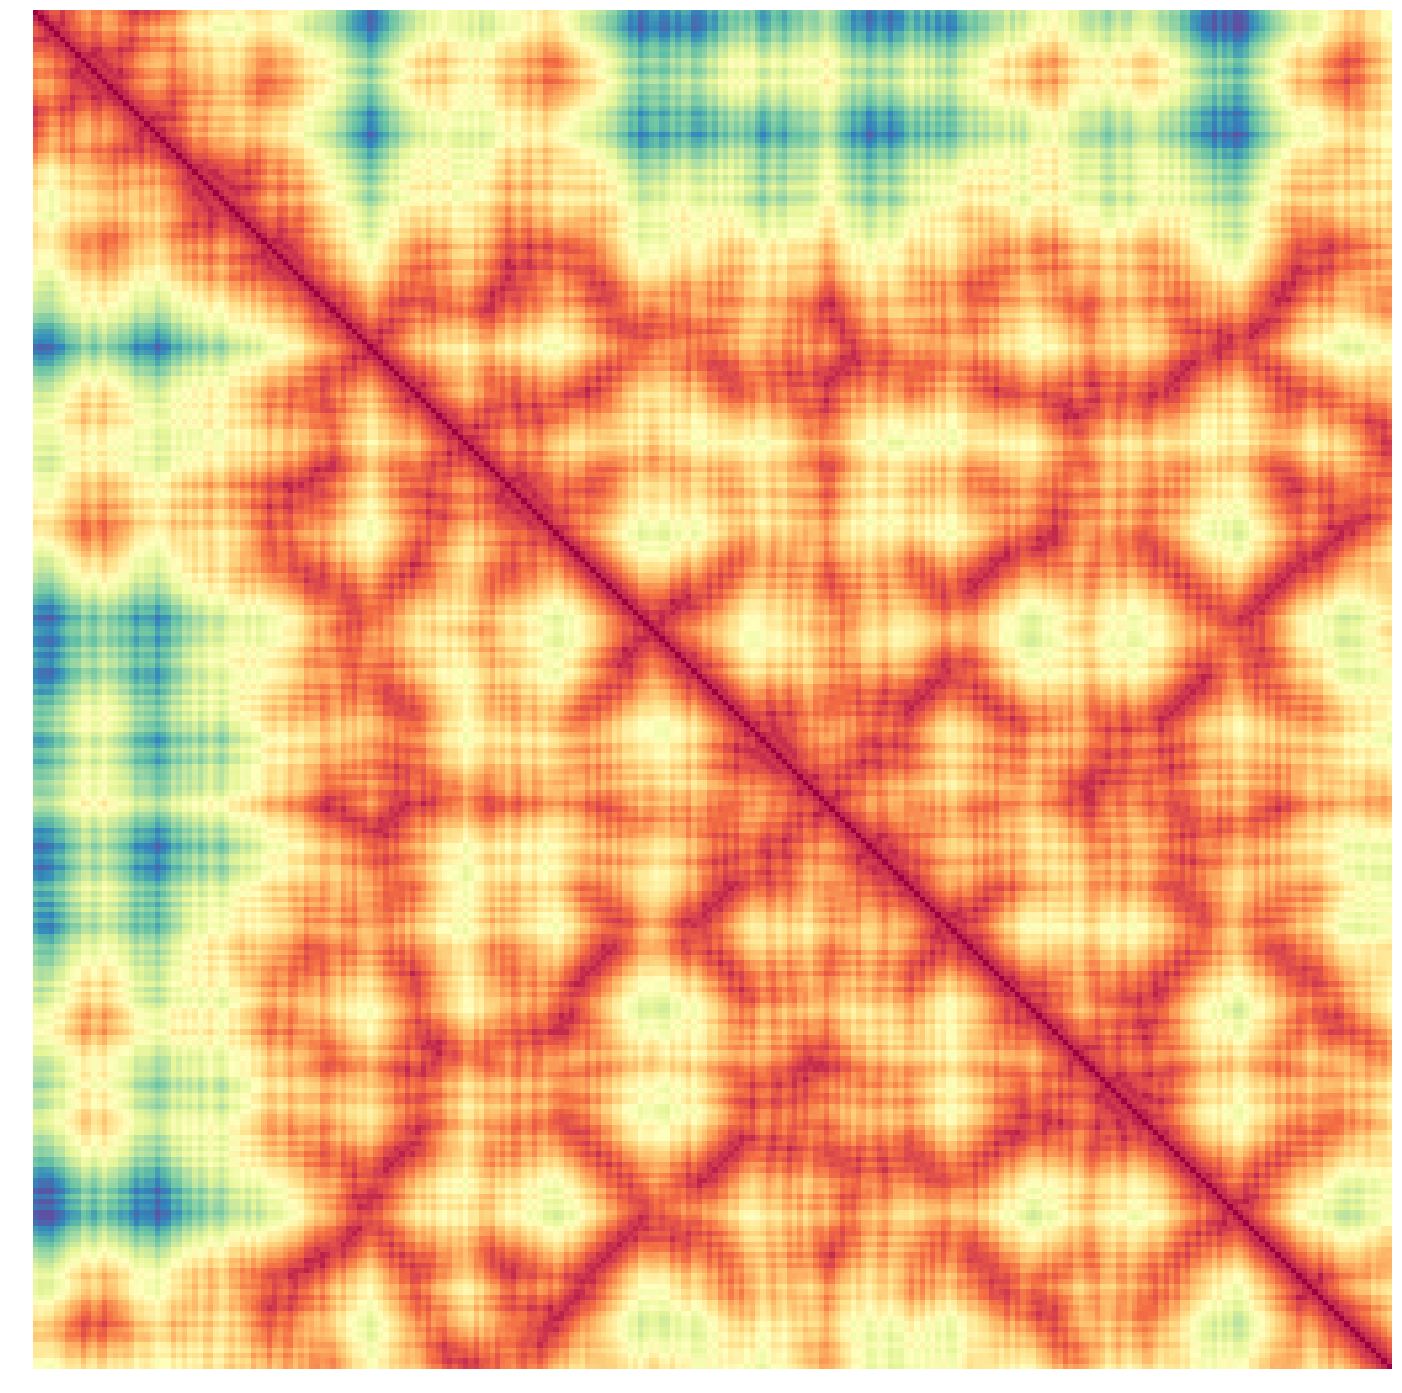

In [113]:
plt.axis('off')
plt.imshow(y[7, :, :, 0], cmap='Spectral', interpolation='nearest')
plt.savefig('Ground_Truth.png', dpi=200, facecolor='w', edgecolor='k',
          orientation='portrait', papertype=None, format=None,
          transparent=False, bbox_inches=None, pad_inches=0.1,
          frameon=True)

In [114]:
plt.rcParams['figure.figsize'] = (10, 5)

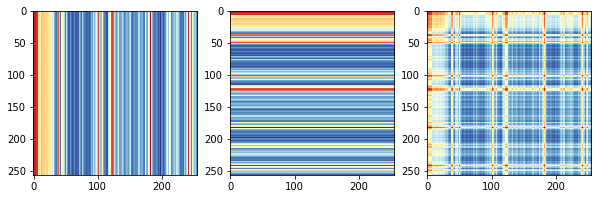

In [115]:
plt.subplot(1, 3, 1)
plt.imshow((x[7, :, :, 8]), cmap = 'RdYlBu', interpolation = 'nearest')
plt.subplot(1, 3, 2)
plt.imshow((x[7, :, :, 9]), cmap = 'RdYlBu', interpolation = 'nearest')
plt.subplot(1, 3, 3)
plt.imshow((x[7, :, :, 8] + x[7, :, :, 9]) / 2 , cmap='RdYlBu', interpolation='nearest')
plt.savefig('8 and 9.png', dpi=200, facecolor='w', edgecolor='k',
          orientation='portrait', papertype=None, format=None,
          transparent=False, bbox_inches=None, pad_inches=0.1,
          frameon=True)


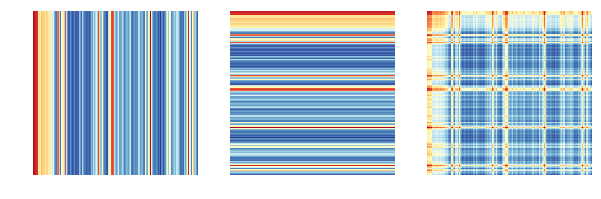

In [116]:
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow((x[7, :, :, 8]), cmap = 'RdYlBu', interpolation = 'nearest')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow((x[7, :, :, 9]), cmap = 'RdYlBu', interpolation = 'nearest')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow((x[7, :, :, 8] + x[7, :, :, 9]) / 2 , cmap='RdYlBu', interpolation='nearest')
plt.savefig('feature8and9.png', dpi=200, facecolor='w', edgecolor='k',
          orientation='portrait', papertype=None, format=None,
          transparent=False, bbox_inches=None, pad_inches=0.1,
          frameon=True)
